# Store Item Demand Forecasting

#### Given 5 years of store-item sales data.
#### Goal is to predict 3 months of sales for 50 different items at 10 different stores.

## Model - Triple Exponential Smoothing (Holt-Winters)

### Univariate Multi-step Output

#### Tools: Jupyter Notebooks, pandas, Matplotlib

In [3]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import autocorrelation_plot

from pylab import rcParams
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'green'

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Load data set

In [4]:
# Data Source: https://www.kaggle.com/c/demand-forecasting-kernels-only
# load dataset
dataset = pd.read_csv("train.csv",parse_dates=['date'])
dataset.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [5]:
# create pivot table of dataset to get total daily sales by item across all stores
table = pd.pivot_table(dataset, values='sales', index=['date'],
                    columns=['item'], aggfunc=np.sum)

table.head()

item         1    2    3    4    5    6    7    8    9    10  ...   41   42  \
date                                                          ...             
2013-01-01  133  327  172  102   83  288  278  416  245  378  ...  103  195   
2013-01-02   99  279  213  110   81  310  291  386  225  397  ...  132  215   
2013-01-03  127  304  193  112   96  309  324  398  265  388  ...  131  215   
2013-01-04  145  359  218  138  108  343  335  430  313  462  ...  122  224   
2013-01-05  149  377  217  144  100  343  377  481  319  449  ...  142  243   

item         43   44   45   46   47   48   49   50  
date                                                
2013-01-01  253  154  396  319  116  277  159  330  
2013-01-02  255  165  393  316  118  281  159  384  
2013-01-03  306  170  459  325  104  280  187  356  
2013-01-04  323  189  450  351  128  296  184  394  
2013-01-05  309  202  533  360  133  344  179  407  

[5 rows x 50 columns]

In [6]:
# table size
table.size

91300

In [7]:
# save transformed data sets
table.to_csv("itemsales.csv",index=True, header = True)

In [8]:
# load data
itemsales = pd.read_csv("itemsales.csv", header = 0)
itemsales ['date'] = pd.to_datetime(itemsales['date'])
itemsales.set_index('date', inplace=True)
itemsales.head()

1    2    3    4    5    6    7    8    9   10  ...   41   42  \
date                                                          ...             
2013-01-01  133  327  172  102   83  288  278  416  245  378  ...  103  195   
2013-01-02   99  279  213  110   81  310  291  386  225  397  ...  132  215   
2013-01-03  127  304  193  112   96  309  324  398  265  388  ...  131  215   
2013-01-04  145  359  218  138  108  343  335  430  313  462  ...  122  224   
2013-01-05  149  377  217  144  100  343  377  481  319  449  ...  142  243   

             43   44   45   46   47   48   49   50  
date                                                
2013-01-01  253  154  396  319  116  277  159  330  
2013-01-02  255  165  393  316  118  281  159  384  
2013-01-03  306  170  459  325  104  280  187  356  
2013-01-04  323  189  450  351  128  296  184  394  
2013-01-05  309  202  533  360  133  344  179  407  

[5 rows x 50 columns]

In [9]:
# train-test split
print(len(itemsales))
train,test = itemsales[:'2016-12-31'],itemsales['2017-01-01':]
print(train.shape)
print(test.shape)

train_idx = train.index
test_idx = test.index

1826
(1461, 50)
(365, 50)


### Persistence
#### establish a baseline of performance

In [10]:
# model each item individually

# create dataframes to store RMSE & Forecasts of each item
items_rmse_pers = []
df_pred_pers = pd.DataFrame()
items = []
# loop over all items
for c in train.columns:
    items.append(c)
    train_series = train[c]
    test_series = test[c]

    # prepare data
    y_train= train_series.values
    y_train = y_train.astype('float32')

    y_test= test_series.values
    y_test = y_test.astype('float32')
    
    # walk-forward validation
    history = [y for y in y_train]
    predictions = list()
    for i in range(len(y_test)):

        # predict
        yhat = history[-1]
        predictions.append(yhat)
        # observation
        obs = y_test[i]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

    # report performance by item
    rmse_pers_item = sqrt(mean_squared_error(y_test, predictions))
    print('RMSE_Item %s: %.3f' %(c,rmse_pers_item))
    items_rmse_pers.append(rmse_pers_item)
    df_pred_pers[c] = predictions

df_rmse_pers = pd.DataFrame(columns=['rmse_pers'])
df_rmse_pers['rmse_pers'] = items_rmse_pers

df_rmse_pers['item'] = items
    
print(df_rmse_pers.head())
    
df_pred_pers['date'] = test.index
df_pred_pers.set_index('date',inplace = True)
print(df_pred_pers.head())

# report performance across all items
rmse_pers = sqrt(mean_squared_error(test, df_pred_pers))
print('RMSE Persistance: %.3f' %rmse_pers)

# save predictions & rmse
df_rmse_pers.to_csv('df_rmse_pers.csv', header=True)
df_pred_pers.to_csv('df_pred_pers.csv', header=True)

RMSE_Item 1: 44.943
RMSE_Item 2: 119.916
RMSE_Item 3: 74.118
RMSE_Item 4: 46.419
RMSE_Item 5: 41.174
RMSE_Item 6: 120.212
RMSE_Item 7: 114.063
RMSE_Item 8: 150.394
RMSE_Item 9: 102.495
RMSE_Item 10: 146.736
RMSE_Item 11: 136.482
RMSE_Item 12: 132.529
RMSE_Item 13: 169.398
RMSE_Item 14: 117.979
RMSE_Item 15: 169.855
RMSE_Item 16: 56.463
RMSE_Item 17: 68.018
RMSE_Item 18: 167.103
RMSE_Item 19: 81.640
RMSE_Item 20: 95.870
RMSE_Item 21: 84.392
RMSE_Item 22: 158.283
RMSE_Item 23: 60.960
RMSE_Item 24: 128.966
RMSE_Item 25: 161.537
RMSE_Item 26: 95.358
RMSE_Item 27: 47.769
RMSE_Item 28: 173.356
RMSE_Item 29: 135.728
RMSE_Item 30: 85.995
RMSE_Item 31: 115.456
RMSE_Item 32: 92.744
RMSE_Item 33: 138.817
RMSE_Item 34: 54.522
RMSE_Item 35: 129.810
RMSE_Item 36: 150.987
RMSE_Item 37: 62.865
RMSE_Item 38: 154.705
RMSE_Item 39: 87.451
RMSE_Item 40: 60.355
RMSE_Item 41: 47.467
RMSE_Item 42: 74.900
RMSE_Item 43: 104.031
RMSE_Item 44: 58.223
RMSE_Item 45: 161.186
RMSE_Item 46: 117.710
RMSE_Item 47: 46.4

### Data Analysis


#### Summary Statistics

In [11]:
print(itemsales.describe())

                 1            2            3            4            5  \
count  1826.000000  1826.000000  1826.000000  1826.000000  1826.000000   
mean    219.815991   585.741512   366.422234   220.102410   183.587076   
std      56.385329   144.684855    92.004531    55.893607    47.440545   
min      84.000000   235.000000   139.000000    94.000000    71.000000   
25%     178.000000   478.000000   298.000000   179.000000   148.000000   
50%     218.000000   578.000000   362.500000   218.000000   181.000000   
75%     258.000000   688.000000   432.000000   259.000000   217.750000   
max     387.000000  1023.000000   662.000000   397.000000   334.000000   

                 6            7            8            9           10  ...  \
count  1826.000000  1826.000000  1826.000000  1826.000000  1826.000000  ...   
mean    585.038883   585.310515   769.500548   513.898686   732.274370  ...   
std     146.356911   145.737924   191.915059   127.718274   181.603768  ...   
min     242.00000

#### Line Plot

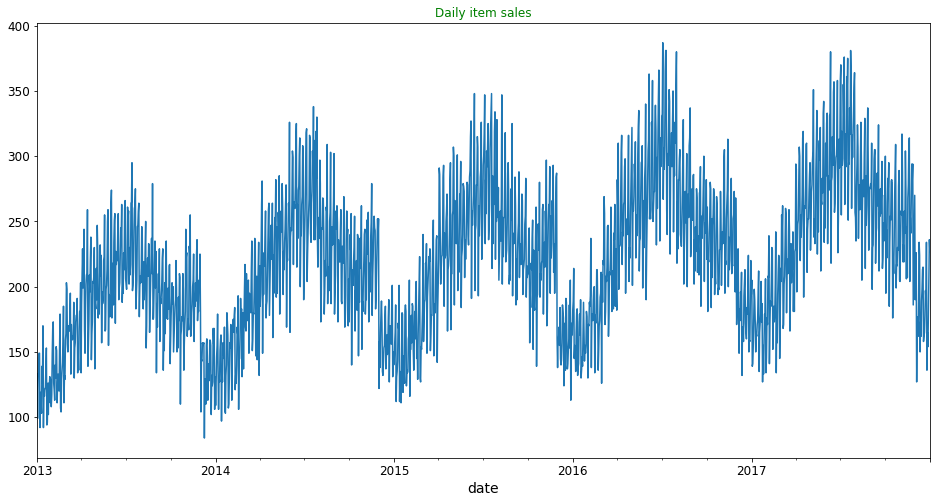

In [12]:
# plot daily item sales of item 1 only
itemsales['1'].plot(figsize=(16,8),title = 'Daily item sales');
plt.ticklabel_format(style='plain',axis = 'y')

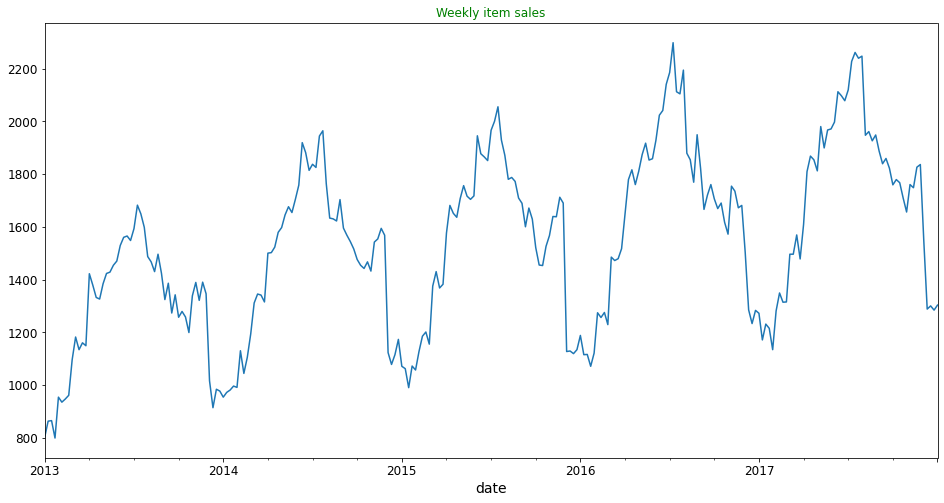

In [13]:
# plot weekly item sales of item 1 only
itemsales['1'].groupby(pd.Grouper(freq="W")).sum().plot(figsize=(16,8),title = 'Weekly item sales');
plt.ticklabel_format(style='plain',axis = 'y')

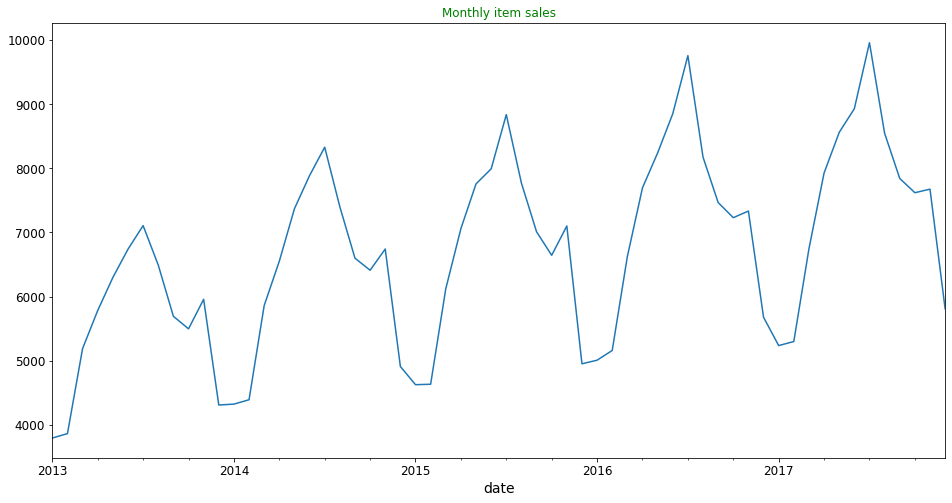

In [14]:
# plot monthly item sales of item 1 only
itemsales['1'].groupby(pd.Grouper(freq="M")).sum().plot(figsize=(16,8),title = 'Monthly item sales');
plt.ticklabel_format(style='plain',axis = 'y')

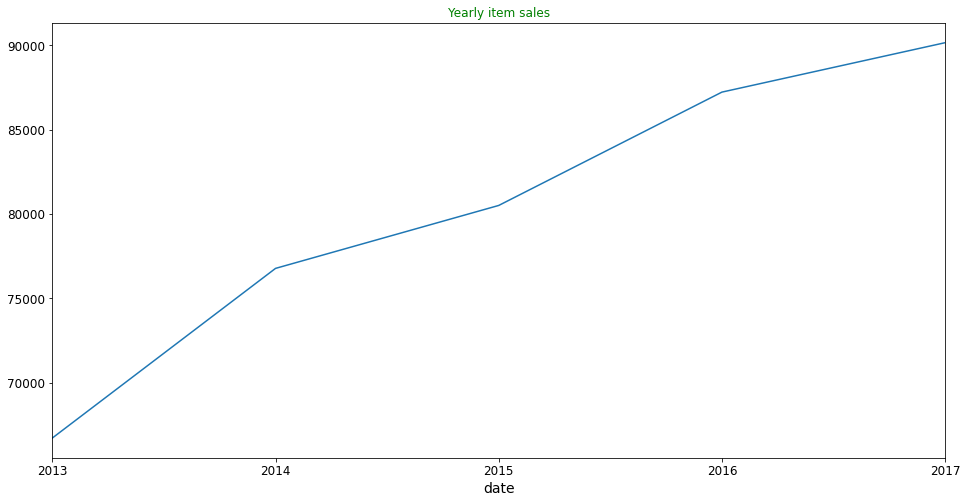

In [15]:
# plot yearly item sales
itemsales['1'].groupby(pd.Grouper(freq="A")).sum().plot(figsize=(16,8),title = 'Yearly item sales');
plt.ticklabel_format(style='plain',axis = 'y')

#### check for stationarity using Augmented Dickey-Fuller test

##### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
##### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [16]:
# calculate stationarity test of time series data of Item 1
Y = itemsales['1'].values
result = adfuller(Y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.051073
p-value: 0.030392
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### Decompose the time series

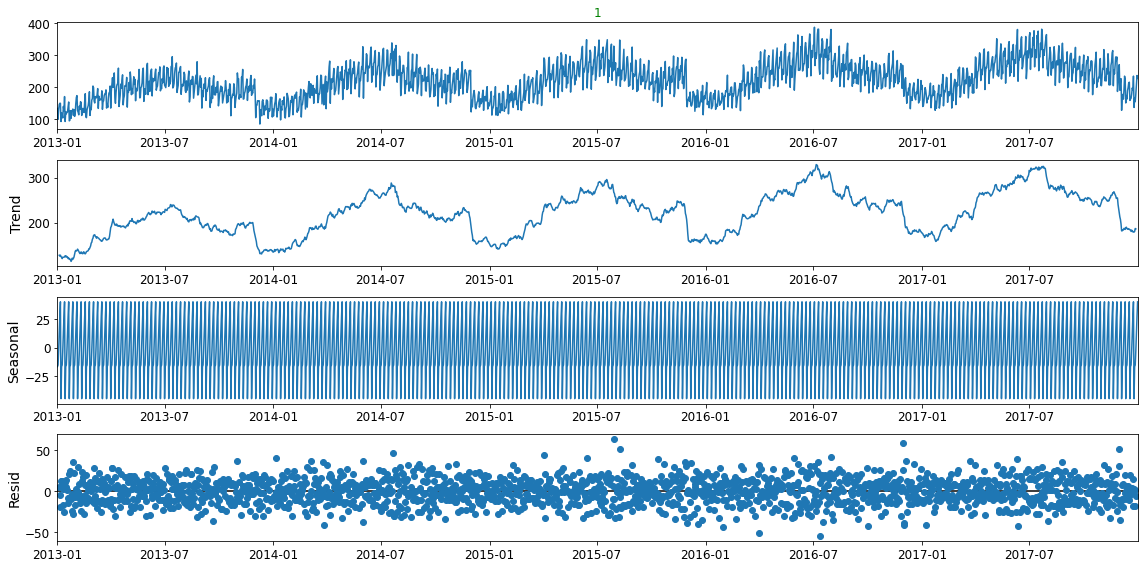

In [17]:
y = itemsales['1']
rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()


### TRIPLE EXPONENTIAL SMOOTHING MODEL
##### https://aimlzone.com/holt-winters/

#####

RMSE_Item 1: 42.305
RMSE_Item 2: 110.016
RMSE_Item 3: 70.394
RMSE_Item 4: 43.437
RMSE_Item 5: 36.526
RMSE_Item 6: 108.244
RMSE_Item 7: 109.341
RMSE_Item 8: 144.900
RMSE_Item 9: 95.441
RMSE_Item 10: 132.220
RMSE_Item 11: 127.627
RMSE_Item 12: 122.611
RMSE_Item 13: 154.206
RMSE_Item 14: 107.043
RMSE_Item 15: 160.026
RMSE_Item 16: 50.784
RMSE_Item 17: 63.674
RMSE_Item 18: 154.327
RMSE_Item 19: 74.619
RMSE_Item 20: 86.403
RMSE_Item 21: 79.852
RMSE_Item 22: 144.263
RMSE_Item 23: 56.947
RMSE_Item 24: 119.619
RMSE_Item 25: 148.922
RMSE_Item 26: 86.784
RMSE_Item 27: 43.336
RMSE_Item 28: 162.137
RMSE_Item 29: 126.082
RMSE_Item 30: 79.592
RMSE_Item 31: 107.851
RMSE_Item 32: 87.922
RMSE_Item 33: 130.821
RMSE_Item 34: 48.961
RMSE_Item 35: 126.048
RMSE_Item 36: 138.960
RMSE_Item 37: 59.893
RMSE_Item 38: 146.533
RMSE_Item 39: 85.387
RMSE_Item 40: 55.876
RMSE_Item 41: 44.799
RMSE_Item 42: 68.529
RMSE_Item 43: 95.362
RMSE_Item 44: 54.422
RMSE_Item 45: 149.512
RMSE_Item 46: 108.862
RMSE_Item 47: 42.750

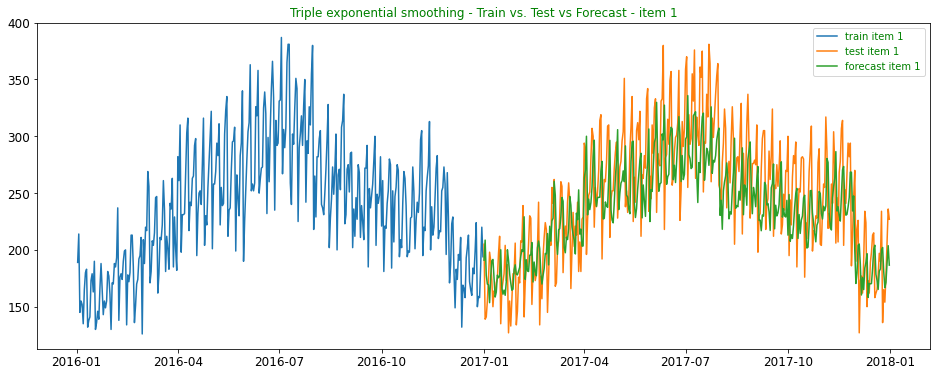

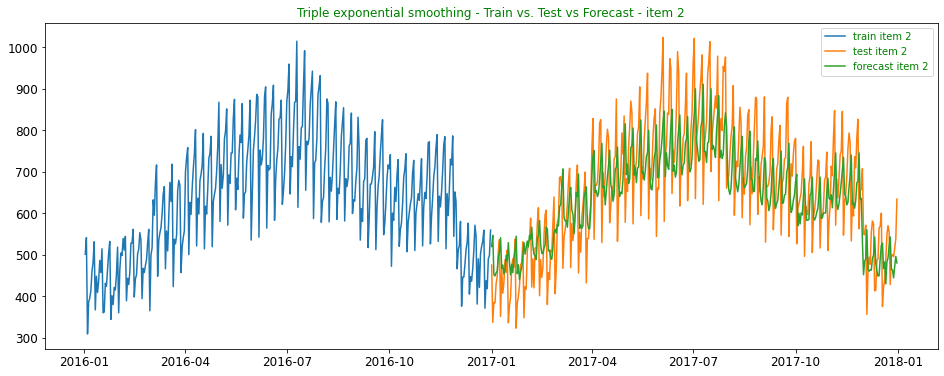

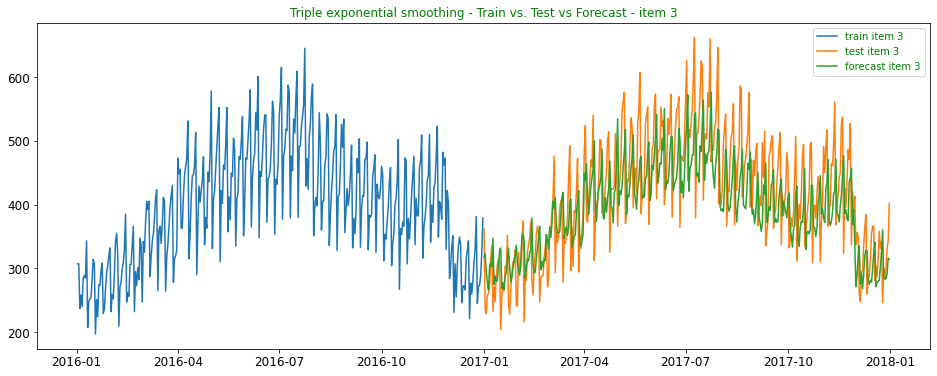

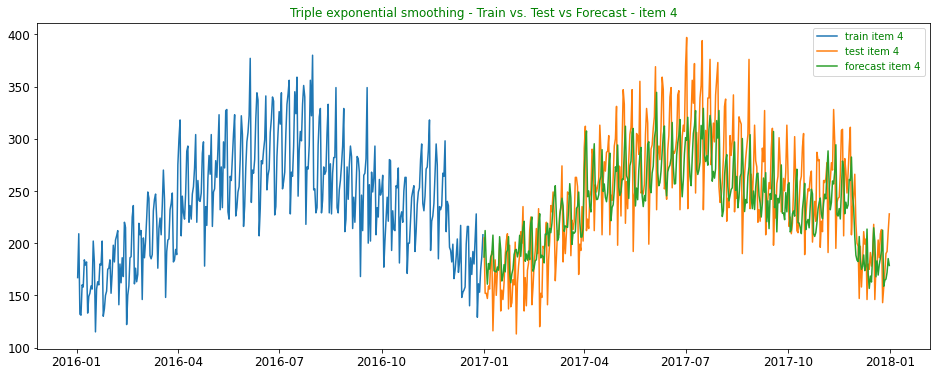

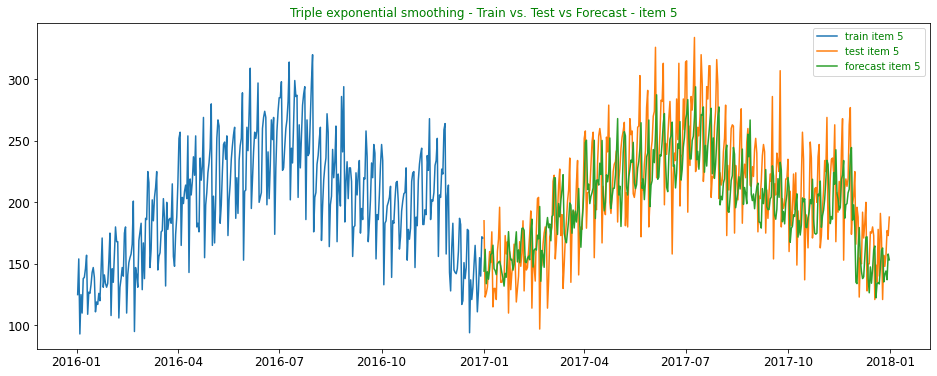

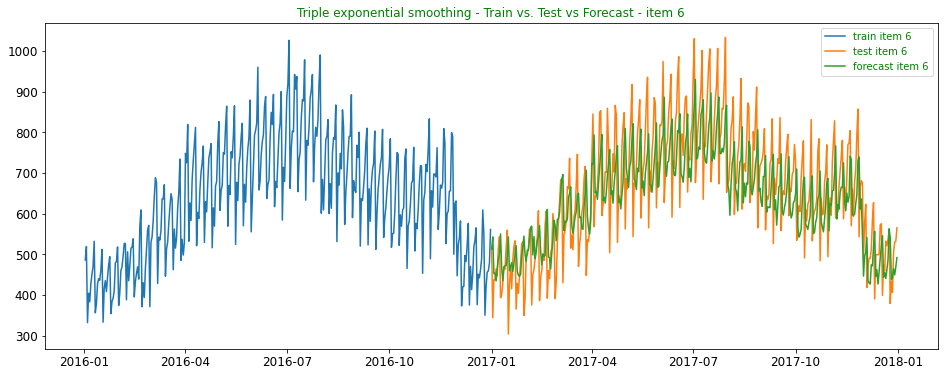

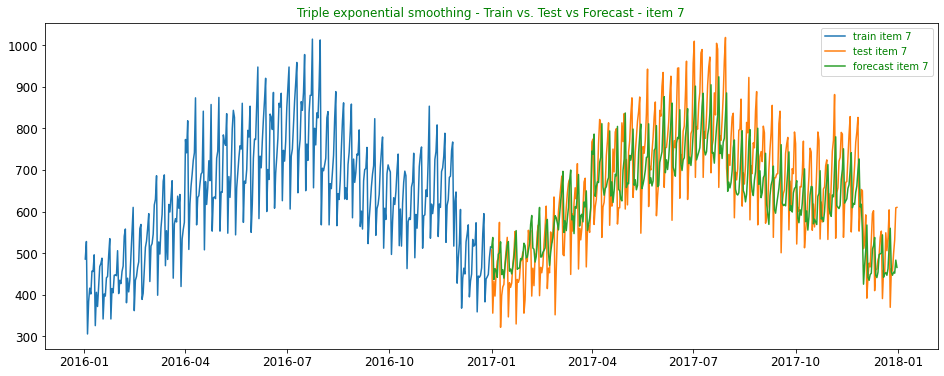

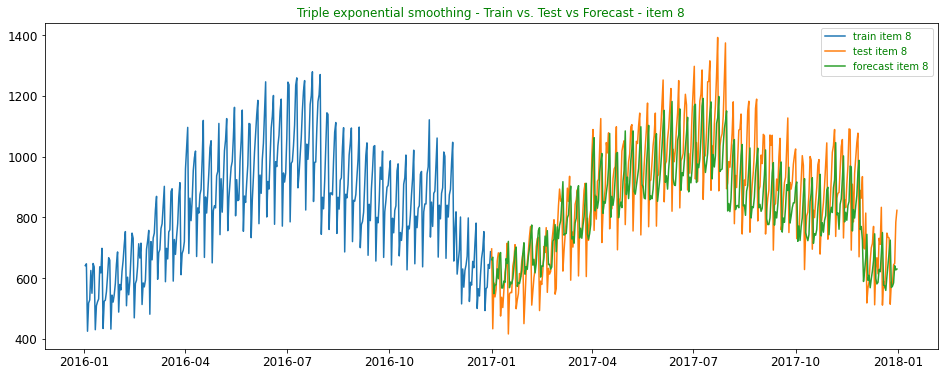

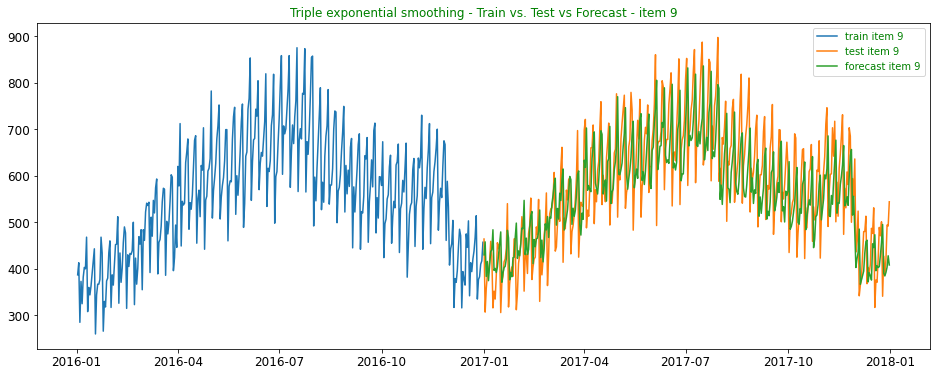

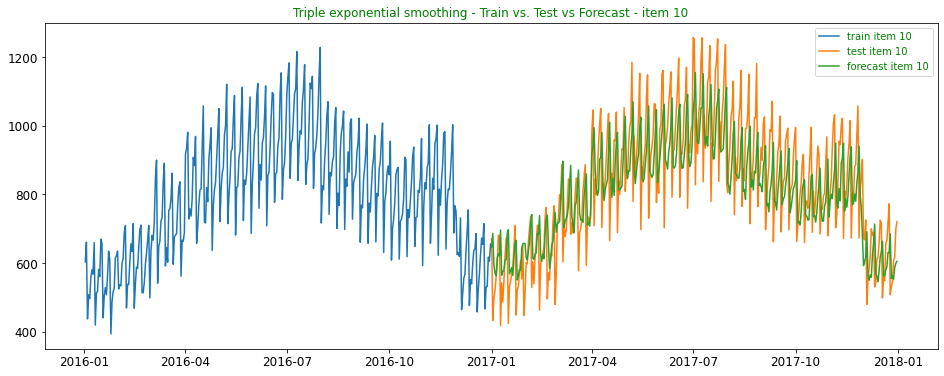

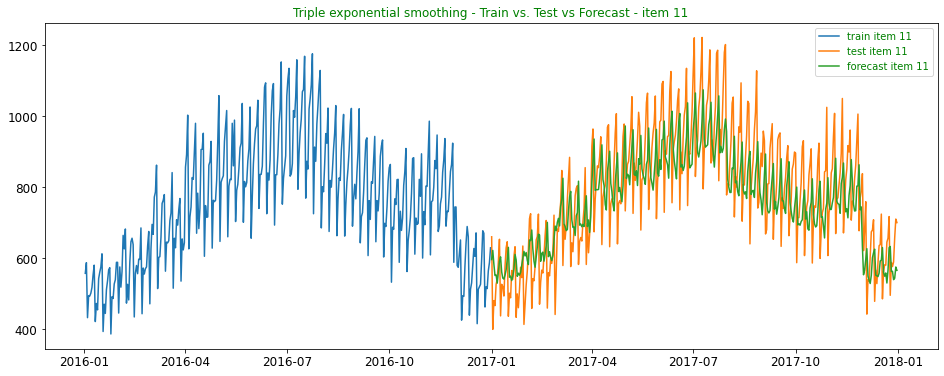

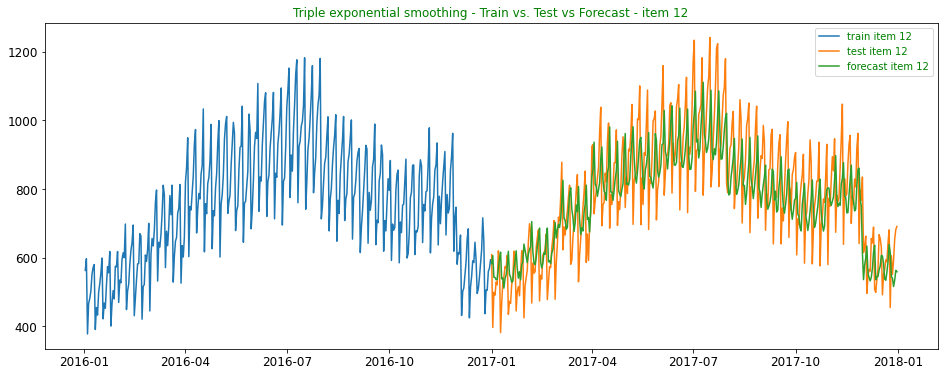

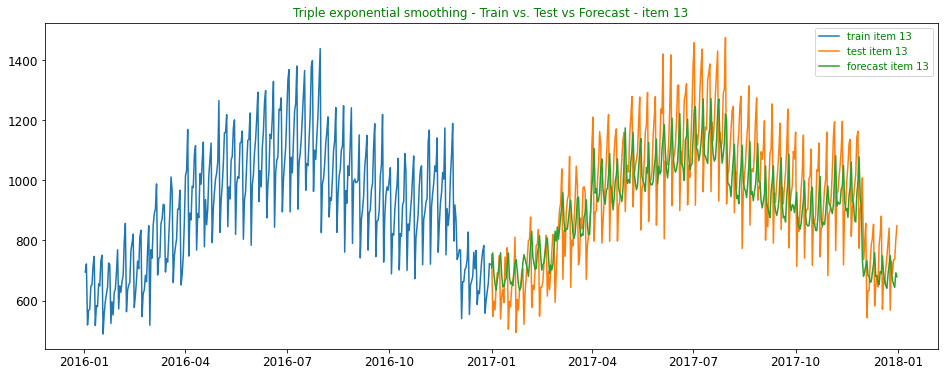

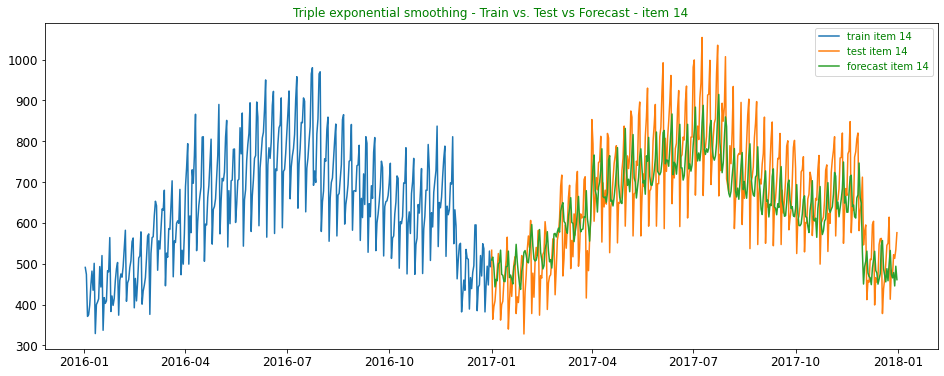

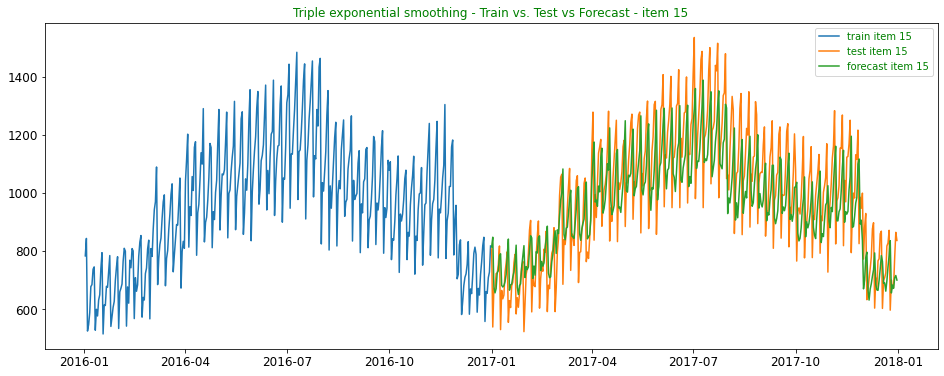

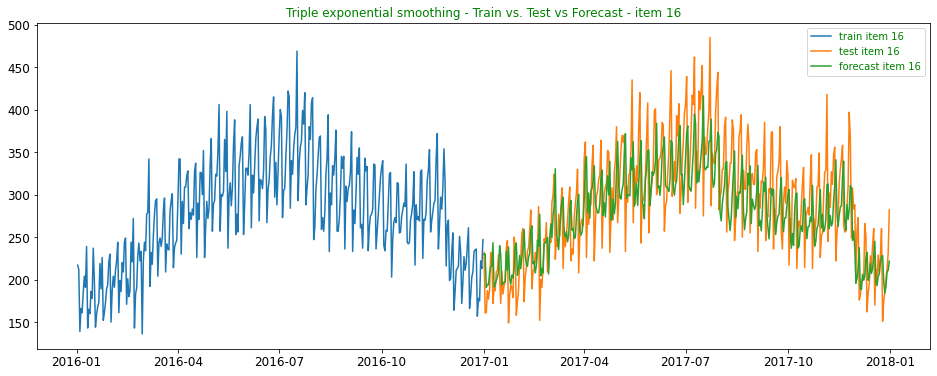

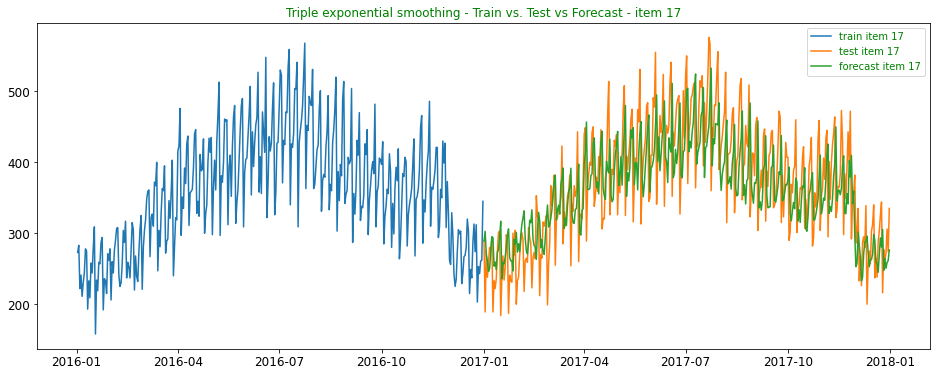

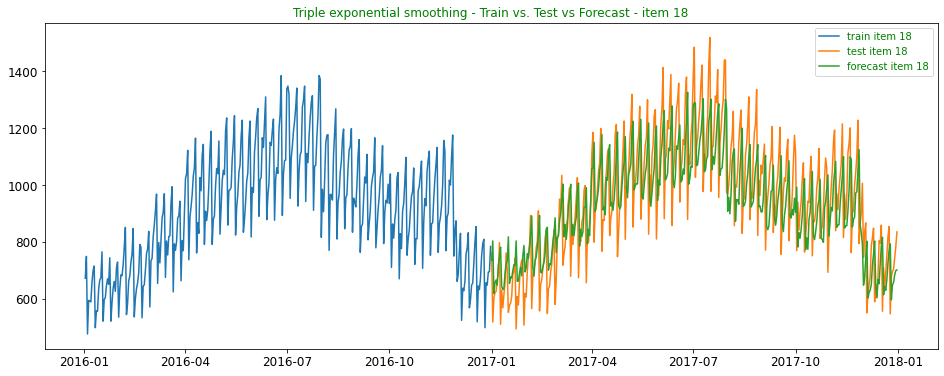

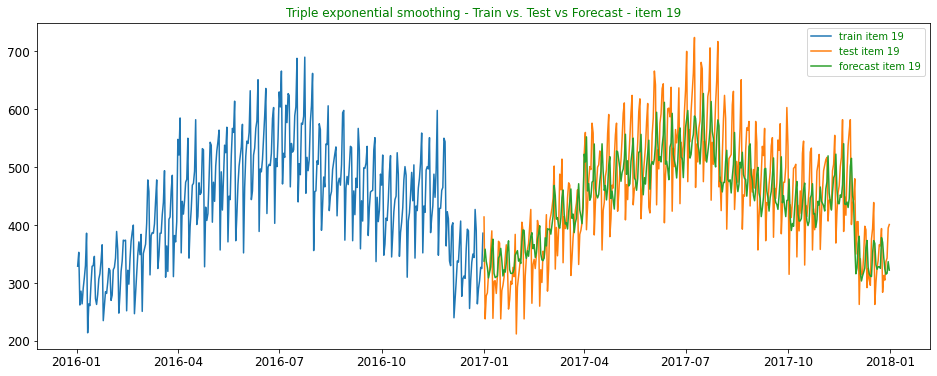

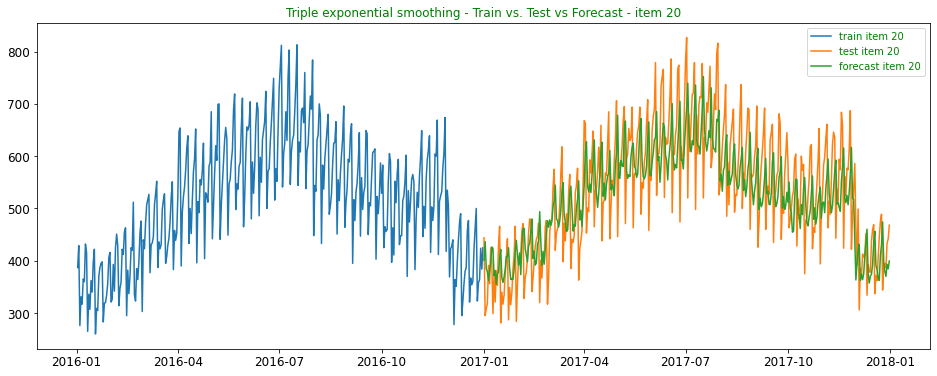

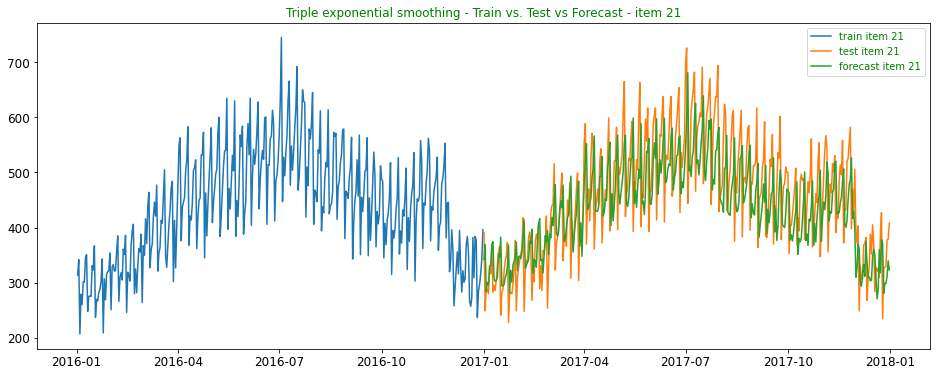

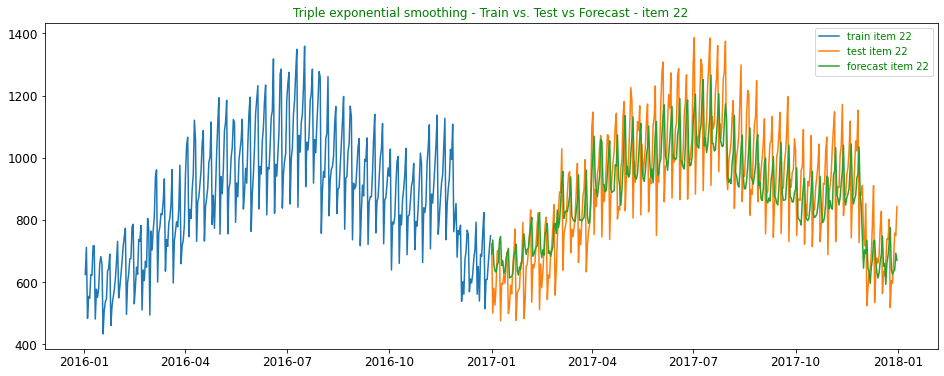

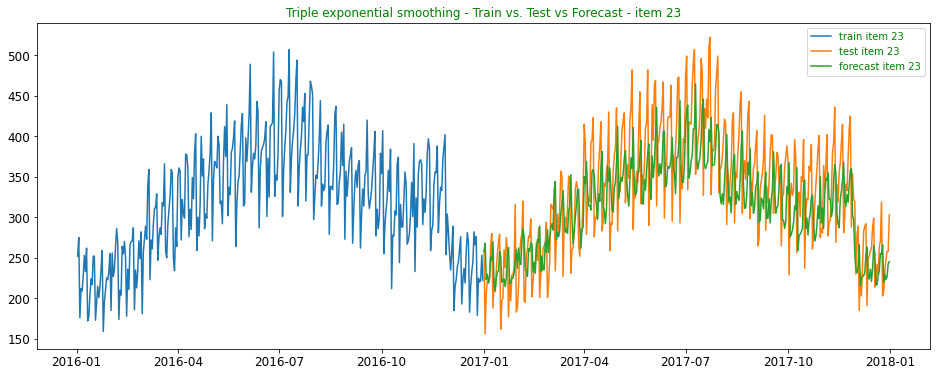

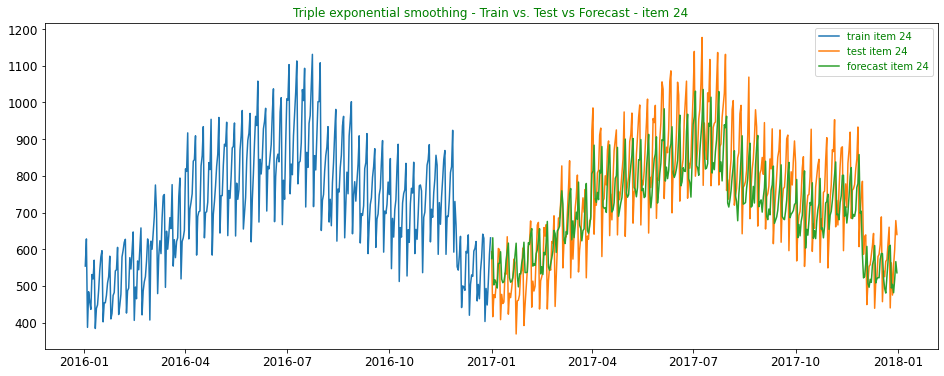

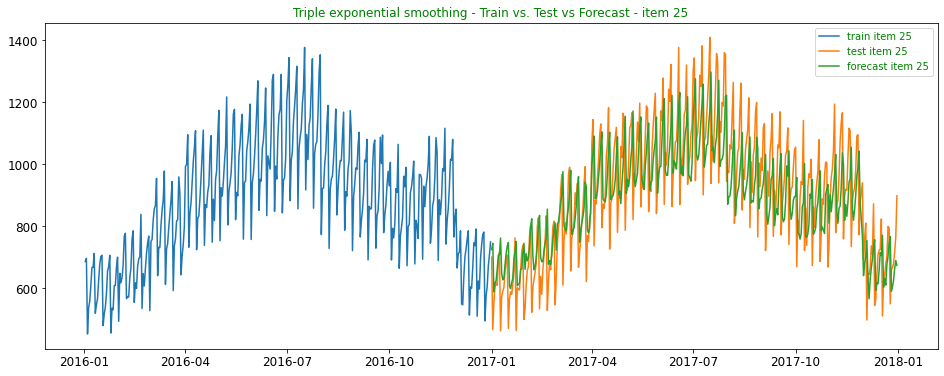

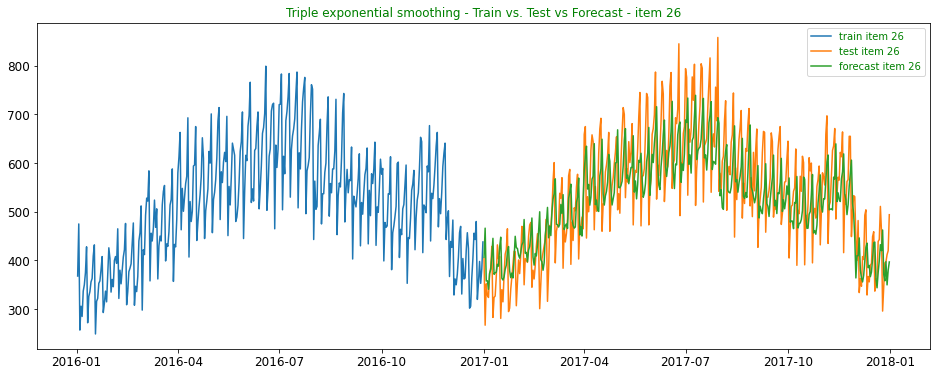

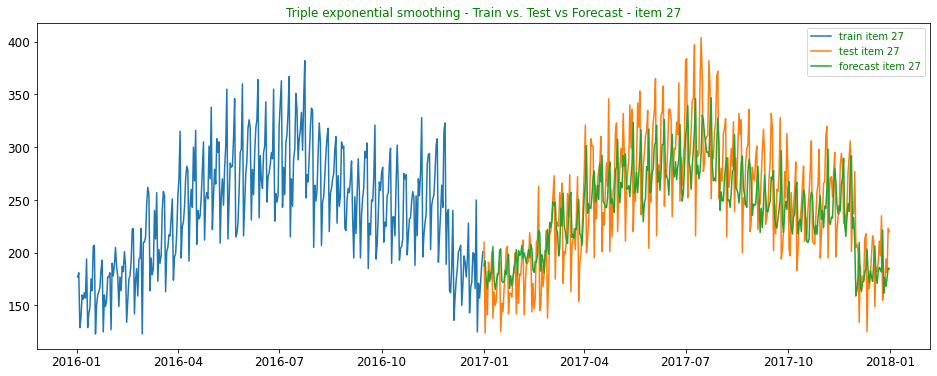

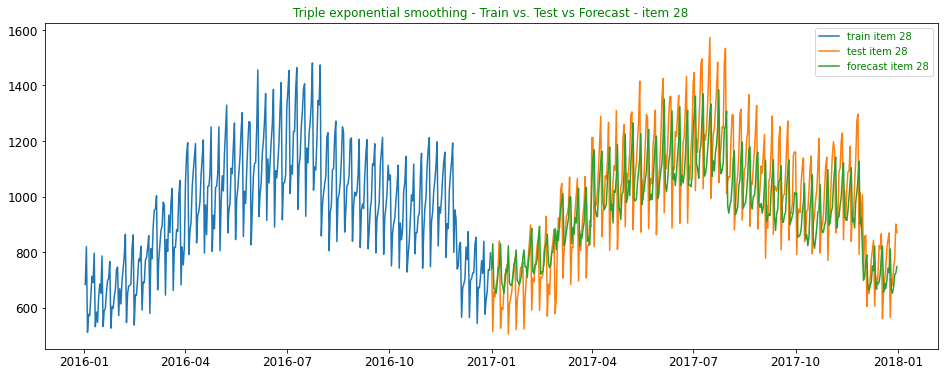

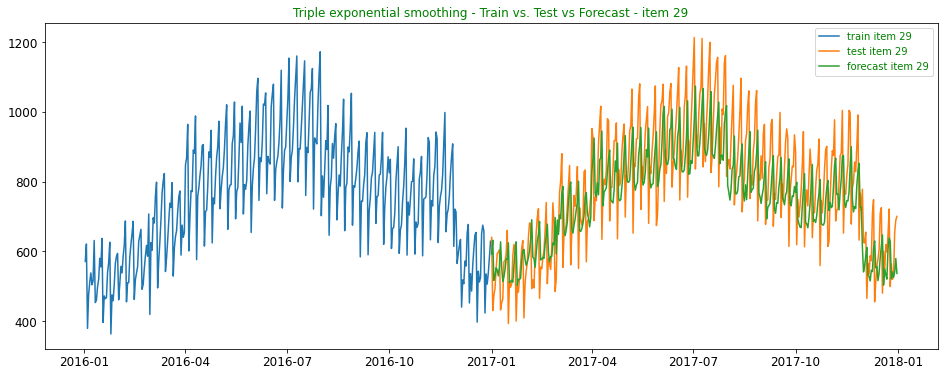

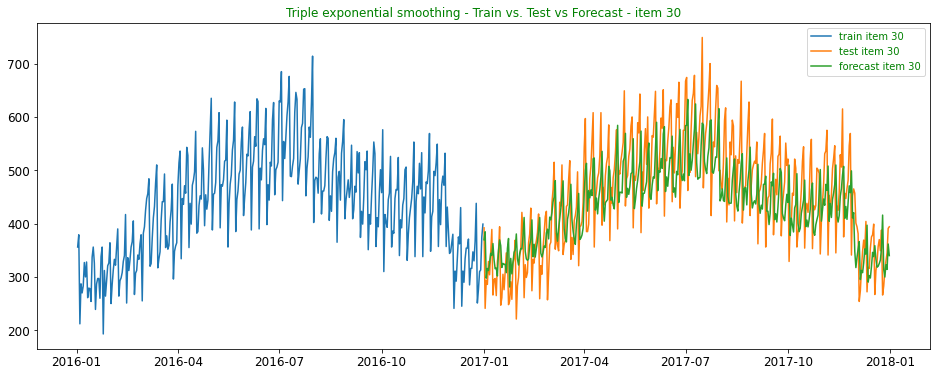

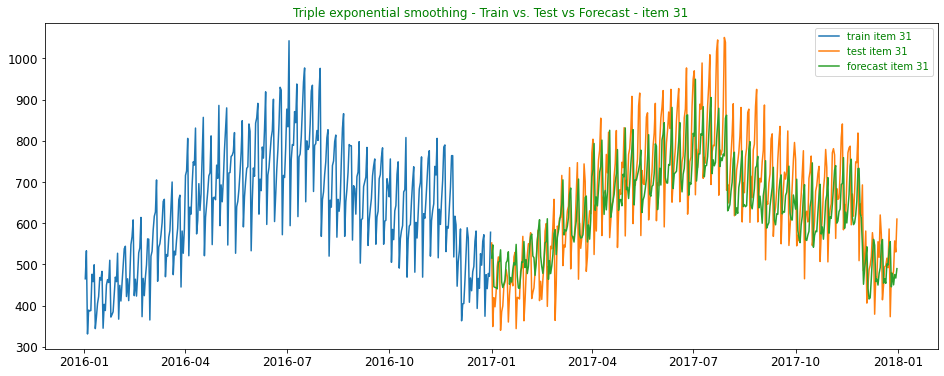

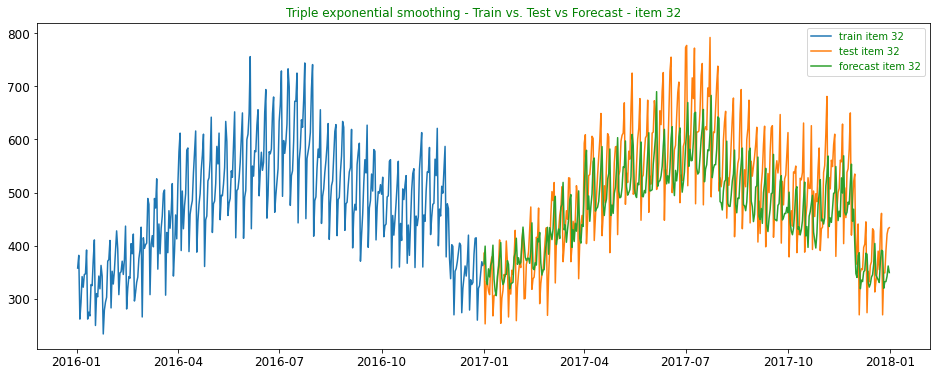

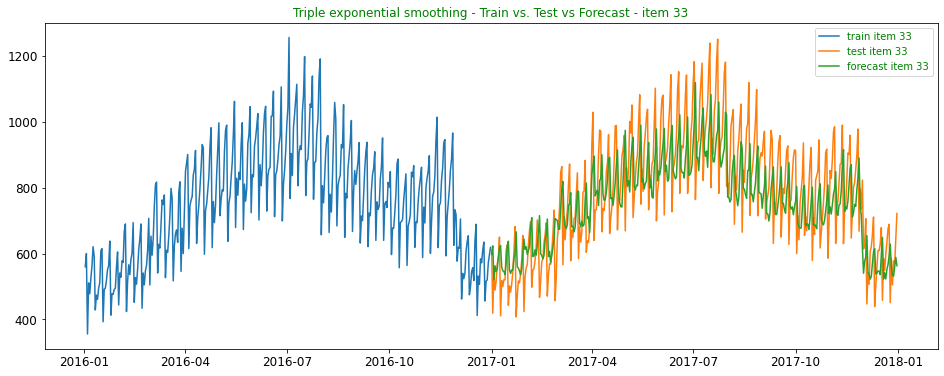

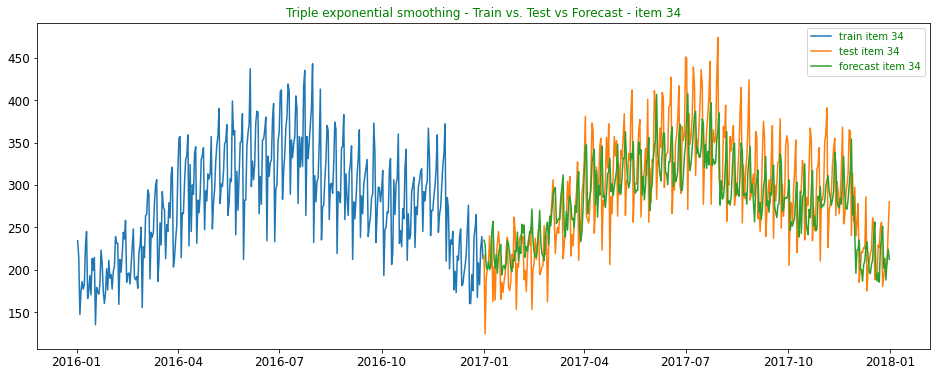

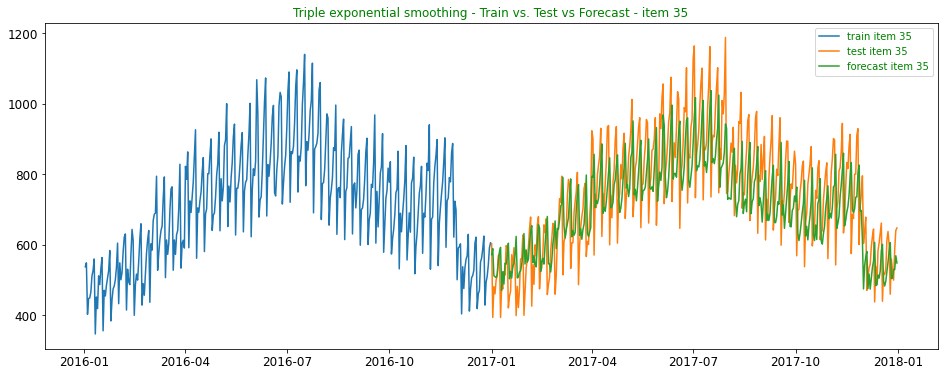

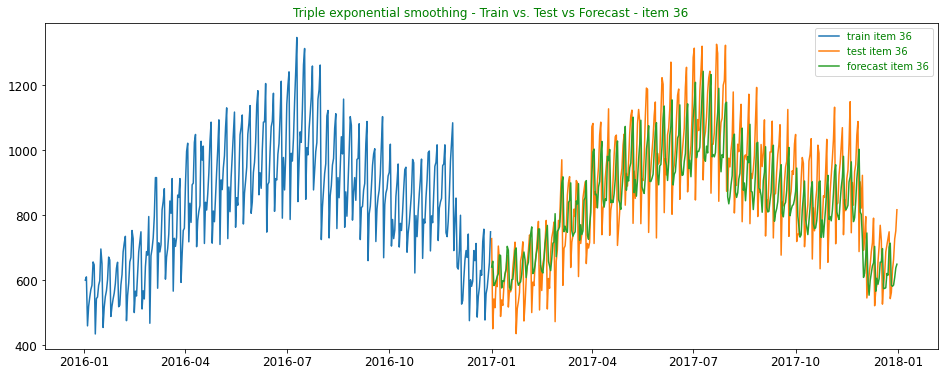

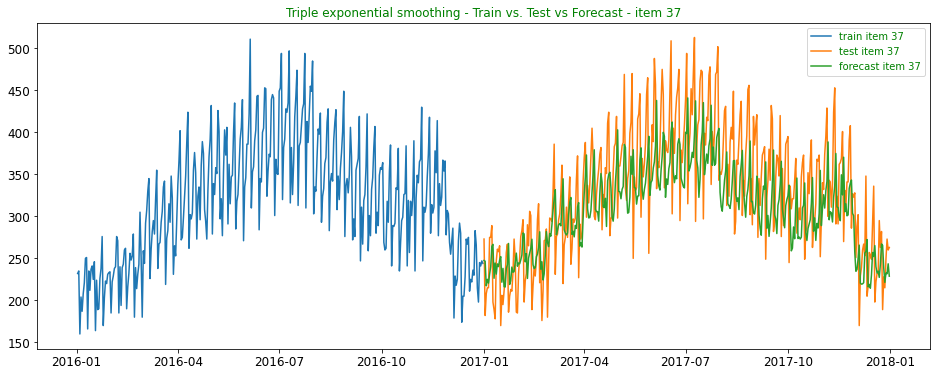

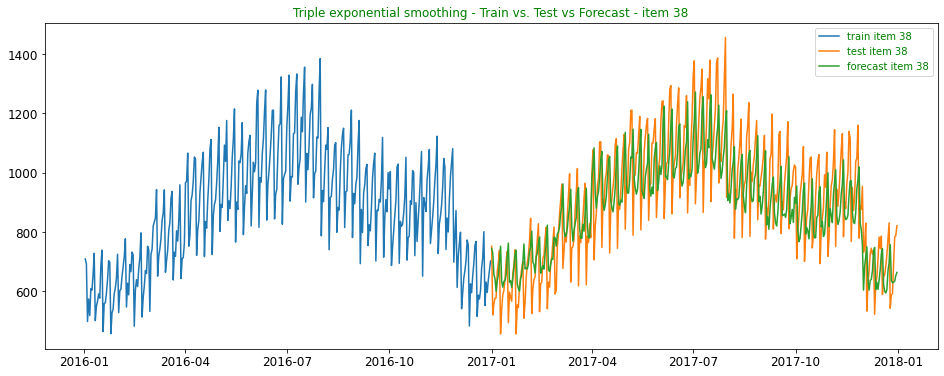

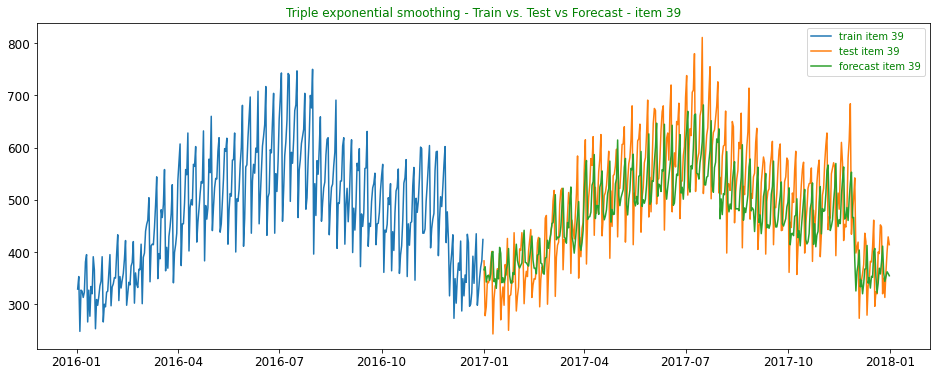

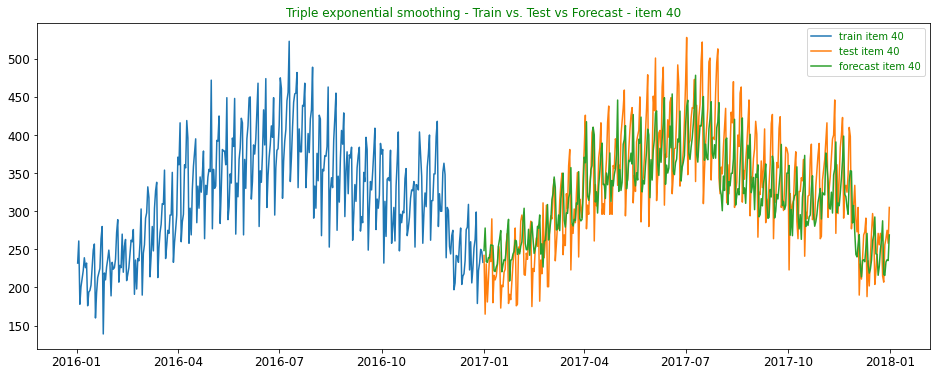

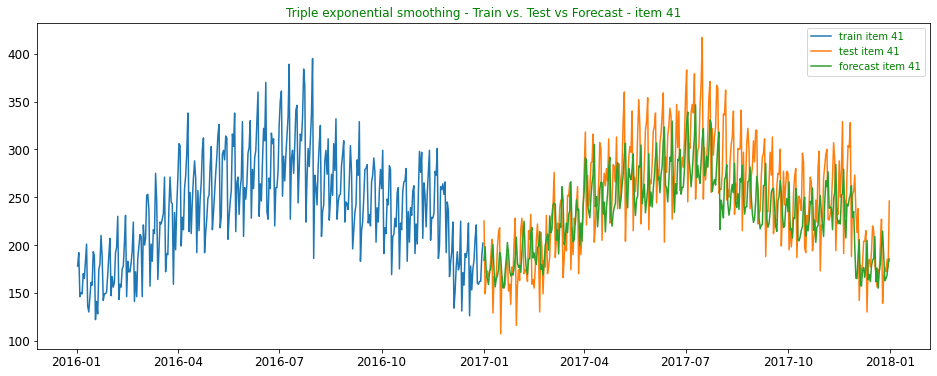

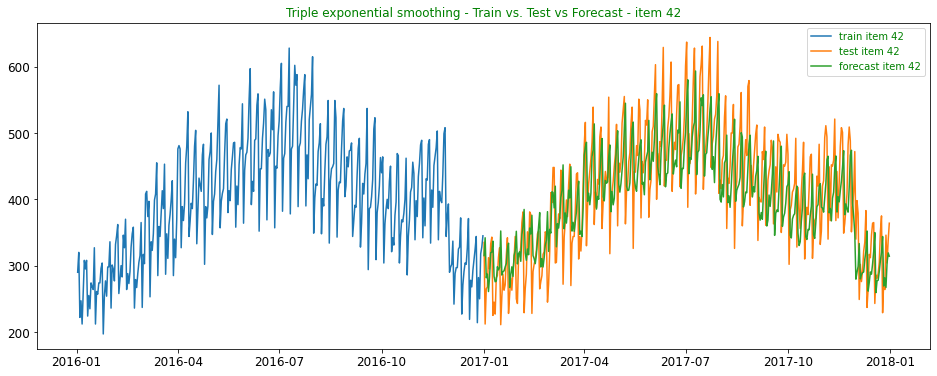

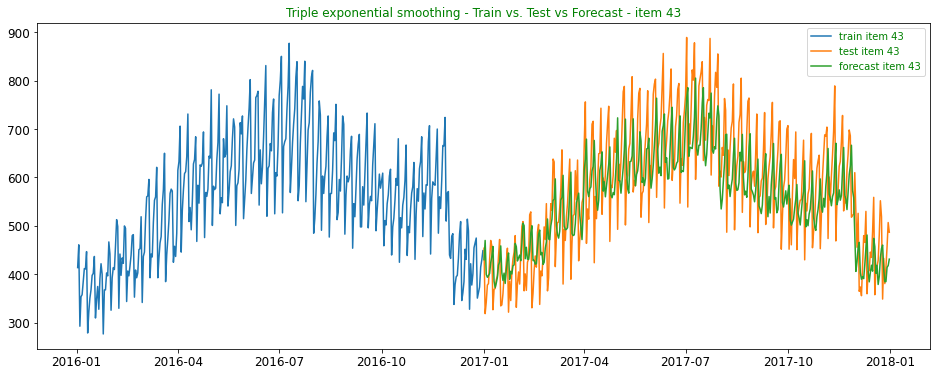

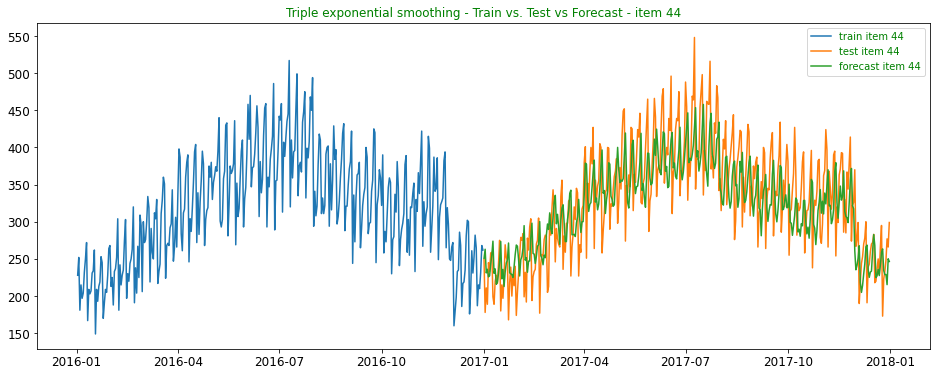

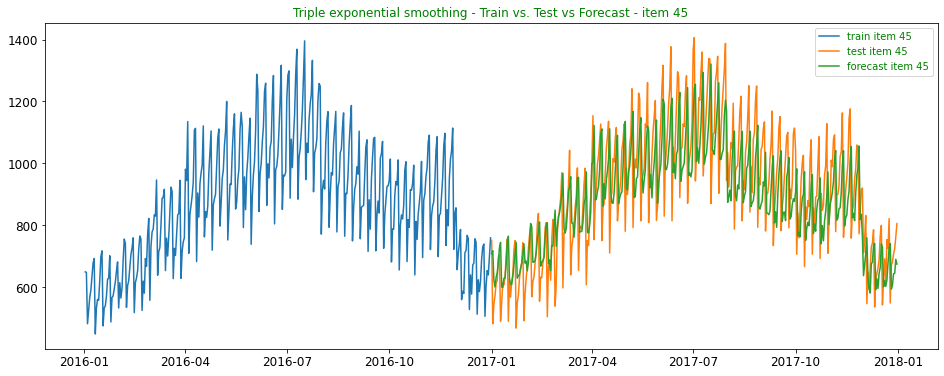

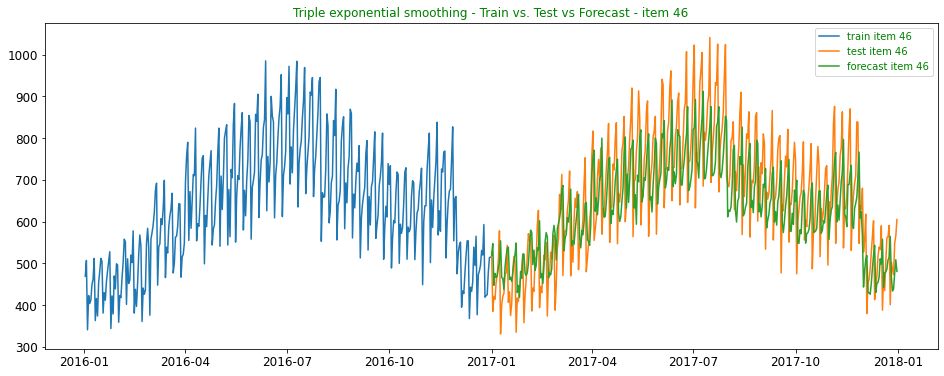

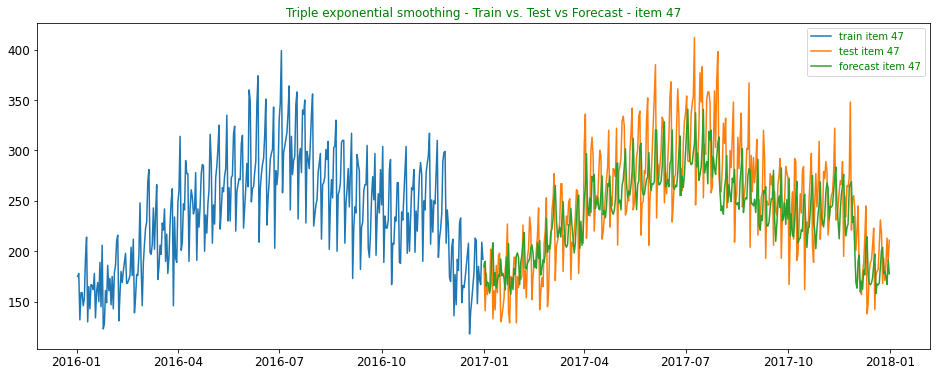

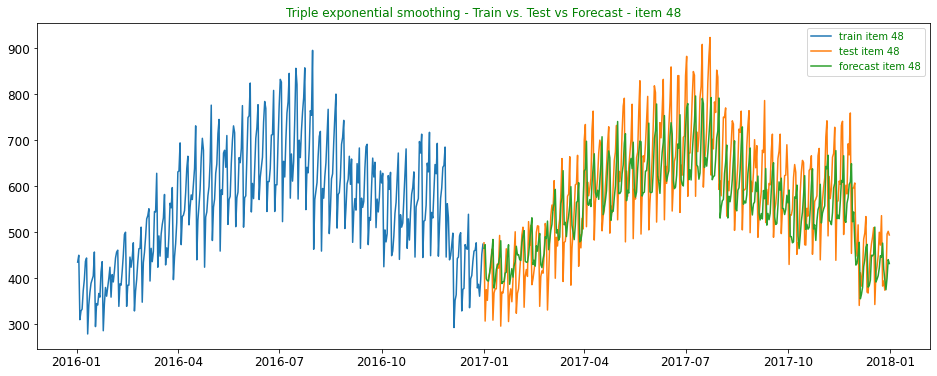

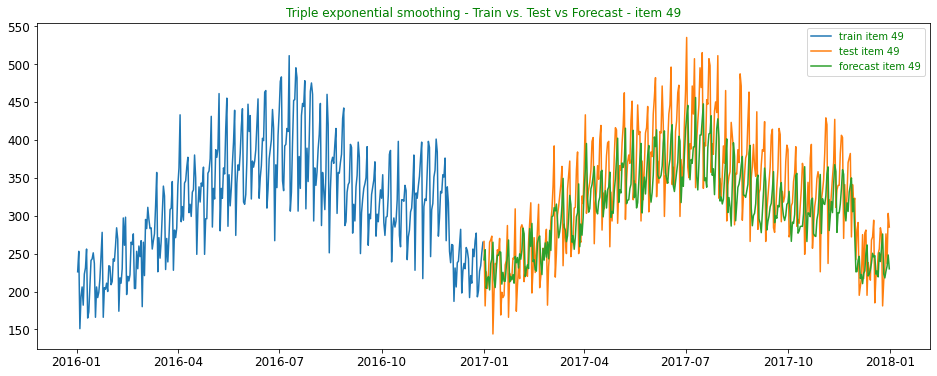

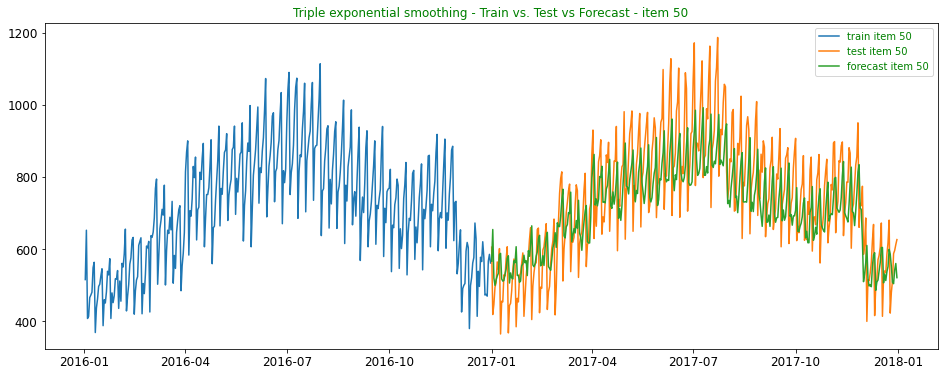

In [18]:
# Model each item series individually
# create dataframes to store RMSE & Forecasts of each item
items_rmse_tes = []
df_pred_tes = pd.DataFrame()
items = []
for c in itemsales.columns:
    items.append(c)
    # choose item to model
    item = itemsales[c]
    # split train, test data (48,12 months )
    train_item = item[:'2016-12-31']
    test_item =  item['2017-01-01':]
    
    # Define & fit model
    tes = ExponentialSmoothing(train_item,seasonal_periods=len(test_item),seasonal='add').fit(optimized=True)
    
    # Forecast
    tes_fcast =tes.forecast(len(test_item)).rename('forecast')

    # report performance by item
    rmse_tes_item = sqrt(mean_squared_error(test_item, tes_fcast))
    print('RMSE_Item %s: %.3f' %(c,rmse_tes_item))
    
    items_rmse_tes.append(rmse_tes_item)
    df_fcast = pd.DataFrame(tes_fcast.values,columns=[c])
    df_pred_tes[c] = df_fcast[c]
    
    # plot train, test, and forecast
    plt.figure(figsize=(16,6))
    plt.plot(train[c][-len(test):] ,label='train item %s' %c)
    plt.plot(test[c], label ='test item %s' %c)
    plt.plot(tes_fcast , label='forecast item %s' %c)
    plt.legend()
    plt.title('Triple exponential smoothing - Train vs. Test vs Forecast - item %s' %c)
    plt.plot()

In [19]:
 print(df_fcast)

             50
0    566.002952
1    653.971100
2    518.921405
3    498.893617
4    514.398061
..          ...
360  507.697184
361  503.597656
362  542.038779
363  559.634015
364  520.298071

[365 rows x 1 columns]


In [20]:
# store model results in DFs
df_rmse_tes = pd.DataFrame(columns=['rmse_tes'])
df_rmse_tes['rmse_tes'] = items_rmse_tes

df_rmse_tes['item'] = items
    
print(df_rmse_tes.head())
    
df_pred_tes['date'] = test_idx
df_pred_tes.set_index('date',inplace = True)
print(df_pred_tes.head())

# report performance across all items
rmse_tes = sqrt(mean_squared_error(test, df_pred_tes))
print('RMSE TES: %.3f' %rmse_tes)

# save predictions & rmse
df_rmse_tes.to_csv('df_rmse_tes.csv', header=True)
df_pred_tes.to_csv('df_pred_tes.csv', header=True) 

     rmse_tes item
0   42.305252    1
1  110.015808    2
2   70.394168    3
3   43.437436    4
4   36.526297    5
                     1           2           3           4           5  \
date                                                                     
2017-01-01  190.971561  519.571433  317.158106  186.717993  144.083492   
2017-01-02  208.628032  546.322110  322.933347  212.059107  161.774336   
2017-01-03  177.634518  451.474566  293.776368  180.080975  133.830863   
2017-01-04  169.883793  448.580449  278.384002  160.722804  143.573112   
2017-01-05  169.268048  456.358493  265.840776  180.485871  137.511759   

                     6           7           8           9          10  ...  \
date                                                                    ...   
2017-01-01  512.690572  513.081089  660.547314  429.968436  646.893632  ...   
2017-01-02  542.595213  537.735435  668.668873  457.872248  686.679351  ...   
2017-01-03  452.259409  436.788537  548.759980  383

### Compare performance - Persistance vs TES

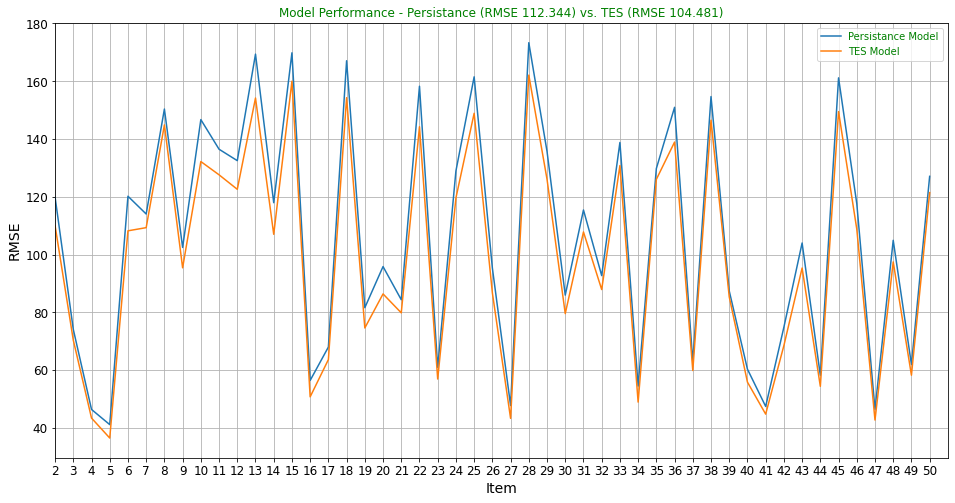

In [21]:
# plot item wise RMSE of Persiatace and SARIMA Models
fig, ax = plt.subplots(figsize=(16,8)) 
ax.plot(df_rmse_pers['item'],df_rmse_pers['rmse_pers'] , label='Persistance Model')
ax.plot(df_rmse_tes['item'],df_rmse_tes['rmse_tes'] , label='TES Model')
ax.set_xlabel('Item')
ax.set_ylabel('RMSE')
ax.set_title('Model Performance - Persistance (RMSE %0.3f) vs. TES (RMSE %0.3f)' %(rmse_pers,rmse_tes)) 
ax.legend()
ax.set_xlim(1,50)
ax.grid(True)

#### The RMSE plot indicates that the TES model performance very closely matches the Persistance Model performance